# Stain segmentation

In this tutorial, we assume we have paired RNA and nuclei staining image for the same tissue slice, and that the two coordinate systems are (roughly) registered. We will use the nuclei staining as the ground-truth location of the nuclei and use this information to obtain cell segmentation. We will do so in the following steps.

<div class="alert alert-info">

See also

[Stain segmentation](../../technicals/cell_segmentation.md#stain-segmentation)

</div>

0. As a pre-processing step, we will refine the alignment between the staining image and the RNA coordinates.
1. Identify and label individual nuclei using a [Watershed](https://en.wikipedia.org/wiki/Watershed_(image_processing))-based approach.
2. Do the same using a deep-learning-based approach called [StarDist](https://github.com/stardist/stardist).
3. [Optional] Augment the StarDist labels using the Watershed labels by copying over labels that are present in the Watershed approach but do not overlap with any labels in the StarDist approach.
4. [Optional] Expand the nuclei labels to cytoplasm.

We will see why Step 3 is important.

In [1]:
import spateo as st
import matplotlib.pyplot as plt

st.config.n_threads = 8
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

network.py (36): The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.


## Load the data

We will be using a truncated mouse coronal section dataset from [Chen et al., 2021](https://doi.org/10.1101/2021.01.17.427004). This is a Stereo-seq dataset that provides ssDNA (nuclei) staining.

In [2]:
!wget "https://drive.google.com/uc?export=download&id=1nONOaUy7utvtXQ3ZPx7R3TePq2Oo4JFM" -nc -O SS200000135IL-D1.ssDNA.tif
!wget "https://drive.google.com/uc?export=download&id=18sM-5LmxOgt-3kq4ljtq_EdWHjihvPUx" -nc -O SS200000135TL_D1_all_bin1.txt.gz

File ‘SS200000135IL-D1.ssDNA.tif’ already there; not retrieving.
File ‘SS200000135TL_D1_all_bin1.txt.gz’ already there; not retrieving.


Load the downloaded UMI counts and nuclei staining image into an AnnData object. For the purposes of cell segmentation, we will be working with an aggregated counts matrix, where the `obs` and `var` of the AnnData correspond to the spatial X and Y coordinates, and each element of the matrix contains the total number of UMIs captured for each X and Y coordinate.

In [3]:
adata = st.io.read_bgi_agg(
    'SS200000135TL_D1_all_bin1.txt.gz', 'SS200000135IL-D1.ssDNA.tif',
)
adata

|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


AnnData object with n_obs × n_vars = 2000 × 2000
    uns: '__type', 'pp', 'spatial'
    layers: 'stain', 'spliced', 'unspliced'

|-----> <select> stain layer in AnnData Object


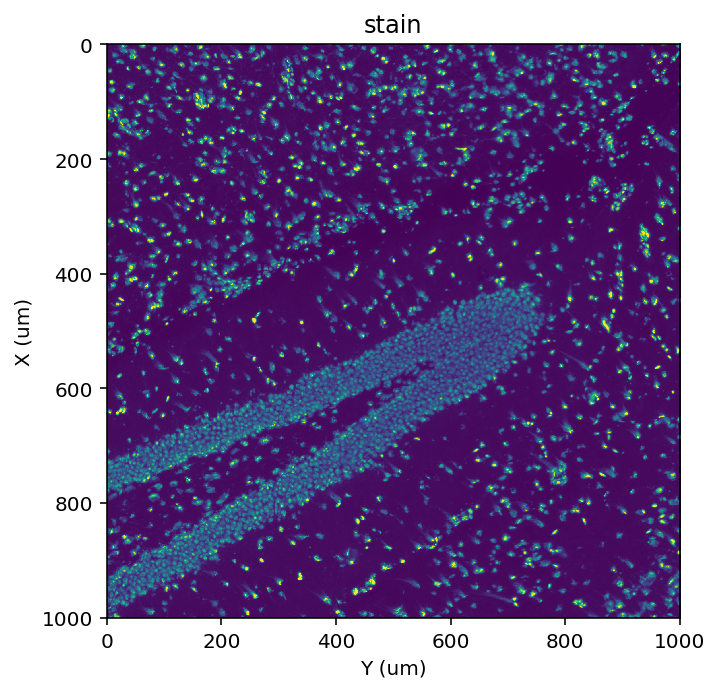

In [4]:
st.pl.imshow(adata, 'stain')

## Refine alignment

The staining image should already be roughly aligned with the RNA coordinates, but there may be minor misalignments. Large misalignments can lead to incorrect UMI aggregation (and thus incorrect cells!). Therefore, we believe it is good practice to refine the alignment provided directly from the spatial transcriptomics assay.

Spateo provides two alignment strategies, but here we will be using the simpler `rigid` alignment because testing showed this to perform well for this sample. For other samples, the `non-rigid` alignment method may perform better.

<div class="alert alert-info">

See also

[Alignment of stain and RNA coordinates](../../technicals/cell_segmentation.md#alignment-of-stain-and-rna-coordinates)

</div>

In [5]:
before = adata.layers['stain'].copy()
st.cs.refine_alignment(adata, mode='rigid', transform_layers=['stain'])

|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object
|-----> Refining alignment in rigid mode.


Loss -4.7450e-03: 100%|██████████| 100/100 [00:09<00:00, 10.01it/s]

|-----> Transforming layers ['stain']
|-----> <select> stain layer in AnnData Object
|-----> <insert> stain to layers in AnnData Object.


|-----> <select> unspliced layer in AnnData Object
|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object


Text(0.5, 1.0, 'after alignment')

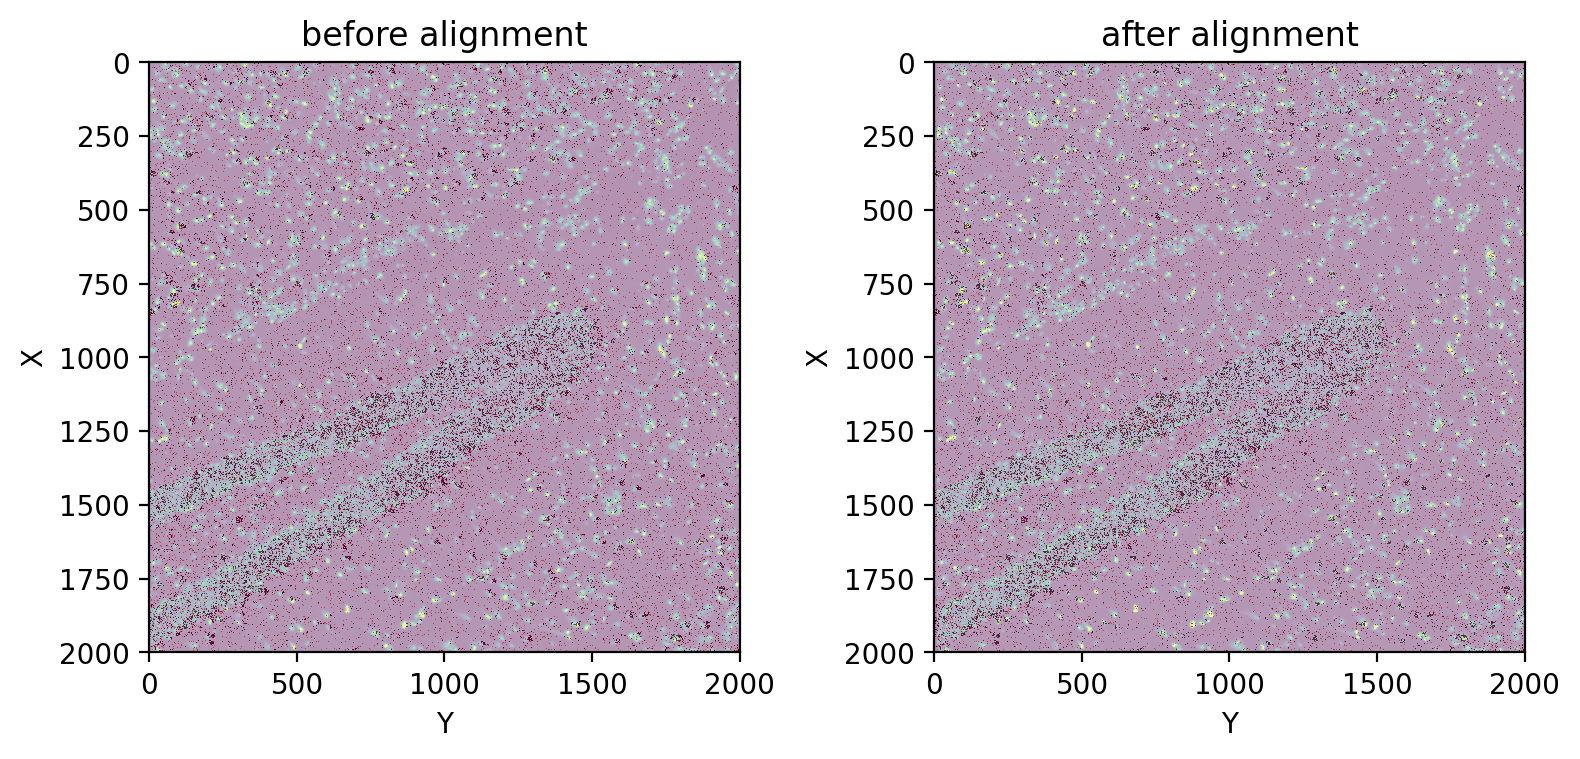

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), tight_layout=True)
axes[0].imshow(before)
st.pl.imshow(adata, 'unspliced', ax=axes[0], alpha=0.6, cmap='Reds', vmax=2, use_scale=False, save_show_or_return='return')
axes[0].set_title('before alignment')
st.pl.imshow(adata, 'stain', ax=axes[1], use_scale=False, save_show_or_return='return')
st.pl.imshow(adata, 'unspliced', ax=axes[1], alpha=0.6, cmap='Reds', vmax=2, use_scale=False, save_show_or_return='return')
axes[1].set_title('after alignment')

We can observe that the alignment has visibly improved.

## Watershed-based approach

Spateo includes a custom Watershed-based approach to segment and label nuclei from the staining image. At a high level, it uses a combination of global and local thresholding to first obtain a mask of nuclei (recall that this is called *segmentation*), and then uses Watershed to assign labels (recall that this is called *labeling*).

<div class="alert alert-info">

See also

[Watershed-based segmentation](../../technicals/cell_segmentation.md#watershed-based-segmentation)

</div>

### Segmentation

|-----> <select> stain layer in AnnData Object
|-----> Constructing nuclei mask from staining image.
|-----> <insert> stain_mask to layers in AnnData Object.
|-----> <select> stain_mask layer in AnnData Object


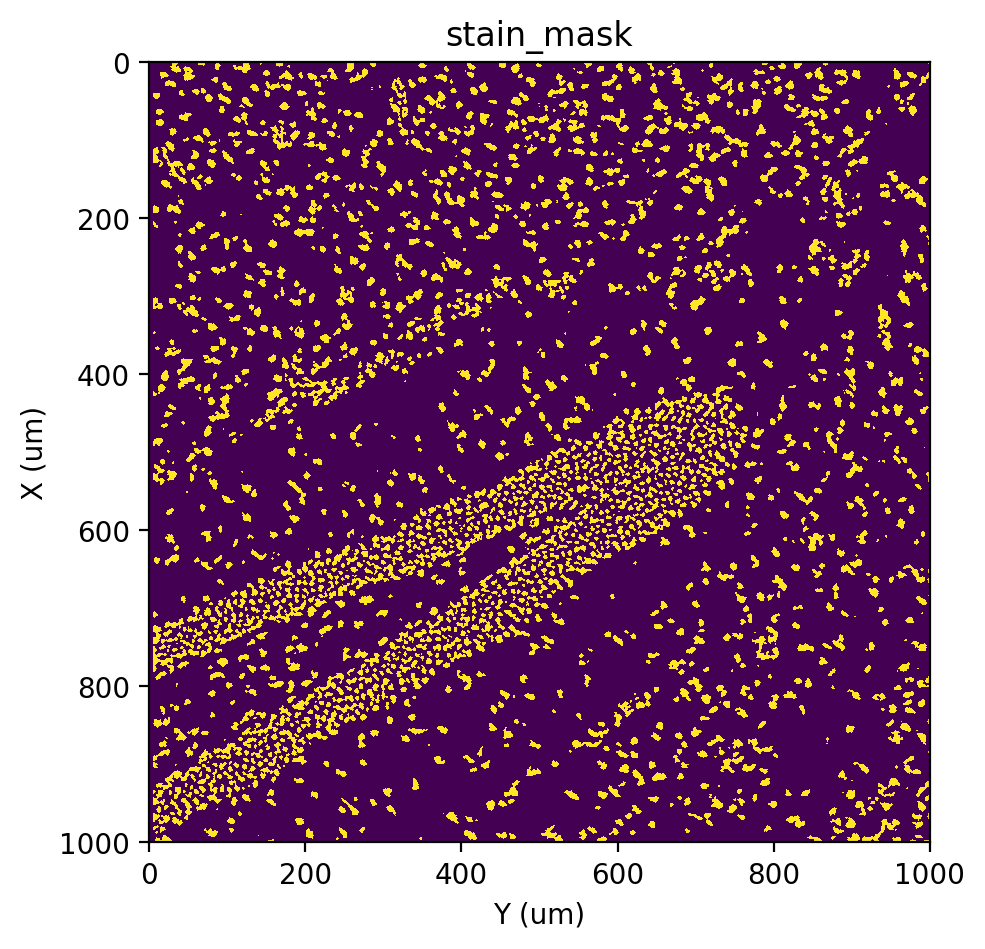

In [7]:
st.cs.mask_nuclei_from_stain(adata)
st.pl.imshow(adata, 'stain_mask')

### Labeling

|-----> <select> stain_mask layer in AnnData Object
|-----> Finding peaks with minimum distance 7.
|-----> <insert> stain_distances to layers in AnnData Object.
|-----> <insert> stain_markers to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stain_mask layer in AnnData Object
|-----> <select> stain_markers layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> watershed_labels to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> watershed_labels layer in AnnData Object


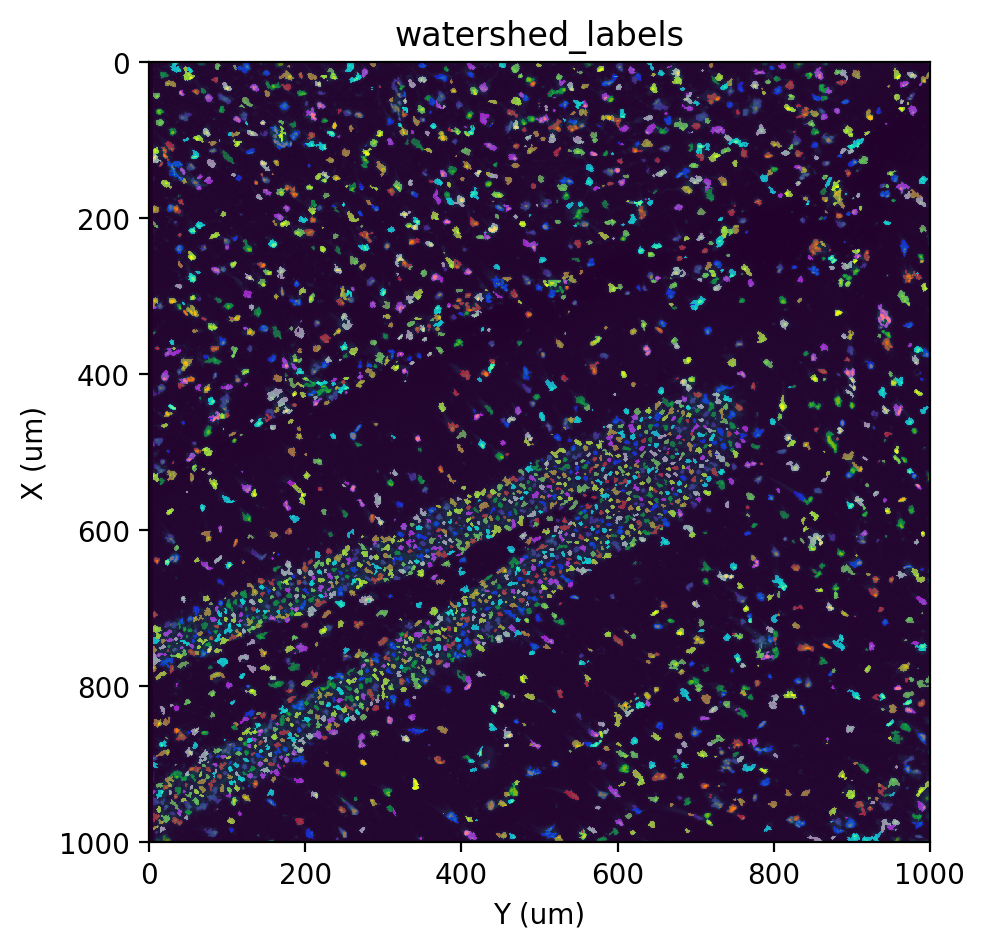

In [8]:
st.cs.find_peaks_from_mask(adata, 'stain', 7)
st.cs.watershed(adata, 'stain', 5, out_layer='watershed_labels')

fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'watershed_labels', labels=True, alpha=0.5, ax=ax)

## Deep learning-based approach

Spateo includes a variety of existing deep-learning approaches for fluroescent nuclei segmentation, such as StarDist, Cellpose and DeepCell. We've found StarDist to perform most consistenly the best among these methods, so that is what we will be using here. Again, note that deep learning-based methods for segmenting cell staining images often combine the segmentation and labeling (i.e. the model outputs the final cell labels).

<div class="alert alert-info">

See also

[Deep learning-based segmentation](../../technicals/cell_segmentation.md#deep-learning-based-segmentation)

</div>

<div class="alert alert-info">
Note
    
We are using `tilesize=-1` here to turn off tiling, since this is a small dataset. Usually, you can leave this to its default value.
    
</div>

|-----> <select> stain layer in AnnData Object
|-----> Equalizing image with CLAHE.
|-----> Running StarDist with model 2D_versatile_fluo.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
|-----> Fixing disconnected labels.
|-----> <insert> stardist_labels to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stardist_labels layer in AnnData Object


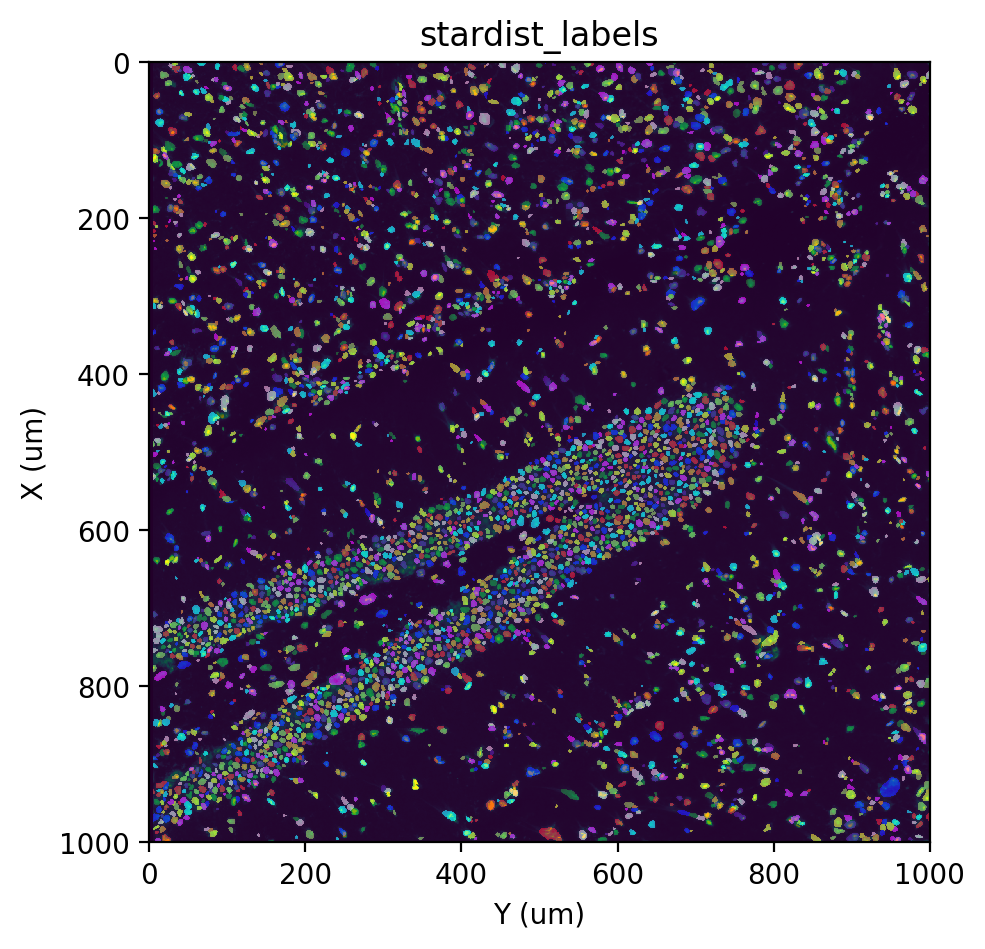

In [20]:
st.cs.stardist(adata, tilesize=-1, equalize=2.0, out_layer='stardist_labels')

fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'stardist_labels', labels=True, alpha=0.5, ax=ax)

## [Optional] Augment labels

Though both the Watershed and StarDist methods perform well in segmenting nuclei, they each have their limitations. The Watershed approach tends to result in rough cell boundaries due to the nature of thresholding, while StarDist sometimes has difficulty identifying nuclei in dense regions (resulting in "holes"). Additionally, because we apply histogram equalization with the `equalize` parameter (which can be turned off by setting `equalize=-1`), sometimes noise in empty regions get amplified and is falsely identified as a cell. We can mitigate these by augmenting the StarDist labels with Watershed labels, copying over Watershed labels that do not overlap with any Stardist labels, and removing Stardist labels that do not overlap with any Watershed labels.

|-----> <select> watershed_labels layer in AnnData Object
|-----> <select> stardist_labels layer in AnnData Object
|-----> <insert> augmented_labels to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> augmented_labels layer in AnnData Object


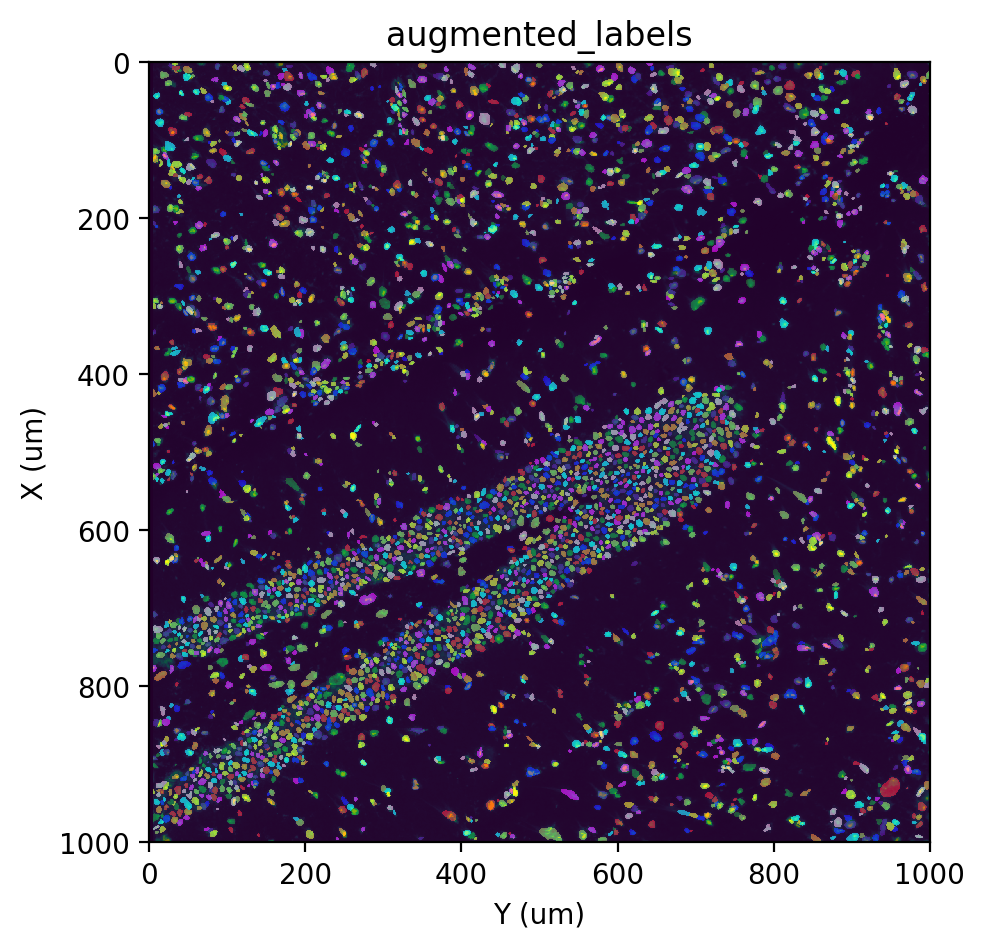

In [21]:
st.cs.augment_labels(adata, 'watershed_labels', 'stardist_labels', out_layer='augmented_labels')

fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'augmented_labels', labels=True, alpha=0.5, ax=ax)

## [Optional] Expand labels to cytoplasm

In the previous sections, we've identified and labeled individual nuclei from the staining image. It is possible to use these labels directly to obtain a cell x gene count matrix (it would actually be a nucleus x gene matrix), but we recommend converting the nuclei labels into cell labels by expanding the nuclei labels to include the cytoplasm.

To do so, we will take advantage of the fact that ssDNA staining weakly stains the cytoplasm, and thus we can identify cytoplasmic regions by thresholding the image with a lenient threshold.

In [22]:
st.cs.mask_cells_from_stain(adata, out_layer='stain_cell_mask')
st.cs.watershed(
    adata, 'stain',
    mask_layer='stain_cell_mask',
    markers_layer='augmented_labels',
    out_layer='cell_labels',
)

|-----> <select> stain layer in AnnData Object
|-----> Constructing cell mask from staining image.
|-----> <insert> stain_cell_mask to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stain_cell_mask layer in AnnData Object
|-----> <select> augmented_labels layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> cell_labels to layers in AnnData Object.


|-----> <select> stain layer in AnnData Object
|-----> <select> cell_labels layer in AnnData Object


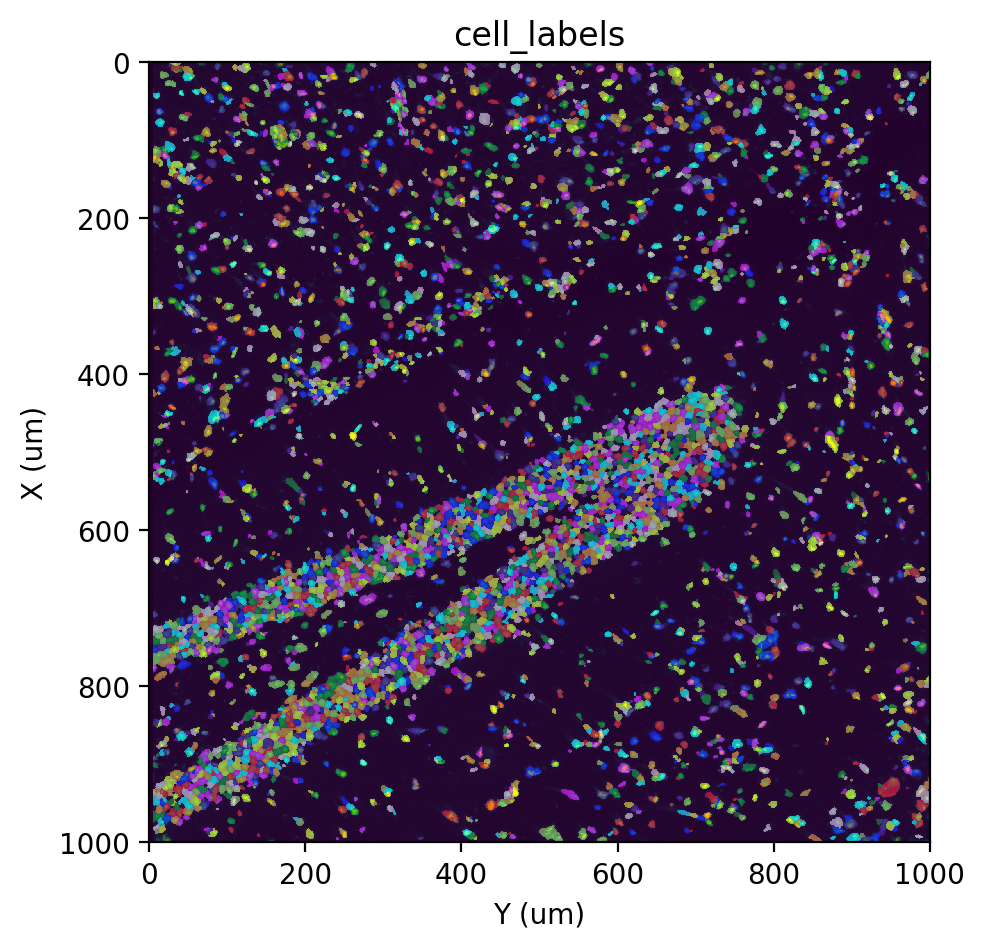

In [23]:
fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'cell_labels', labels=True, alpha=0.5, ax=ax)

<div class="alert alert-info">
Note
    
When visualizing labels, some cells may appear "merged" due to the limited number of colors used (10 by default). This is only a visual effect.
    
</div>

An alternative for labeling strategies that is highly specific to the nuclei is to simply expand each label by some distance.

|-----> <select> augmented_labels layer in AnnData Object
|-----> Expanding labels.


Expanding: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

|-----> <insert> augmented_labels_expanded to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> augmented_labels_expanded layer in AnnData Object


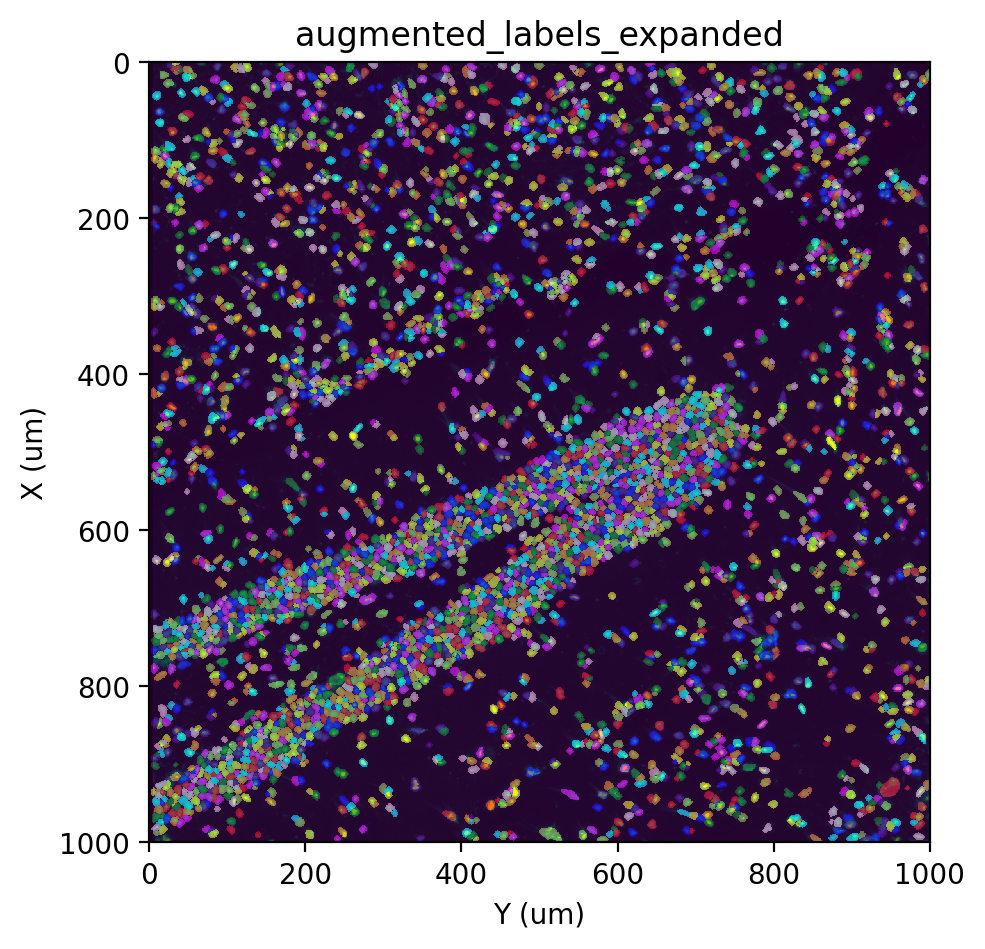

In [26]:
st.cs.expand_labels(adata, 'augmented_labels', distance=5, max_area=400)

fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'augmented_labels_expanded', labels=True, alpha=0.5, ax=ax)

## Obtain a cell x gene matrix

Finally, we will use our segmentation results to obtain the desired cell-by-gene counts matrix.

But first, we will expand all the cell labels by some amount to mitigate the effects of RNA diffusion. The distance that should be expanded will depend on the level of RNA diffusion in the data.

|-----> <select> cell_labels layer in AnnData Object
|-----> Expanding labels.


Expanding: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

|-----> <insert> cell_labels_expanded to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> cell_labels_expanded layer in AnnData Object


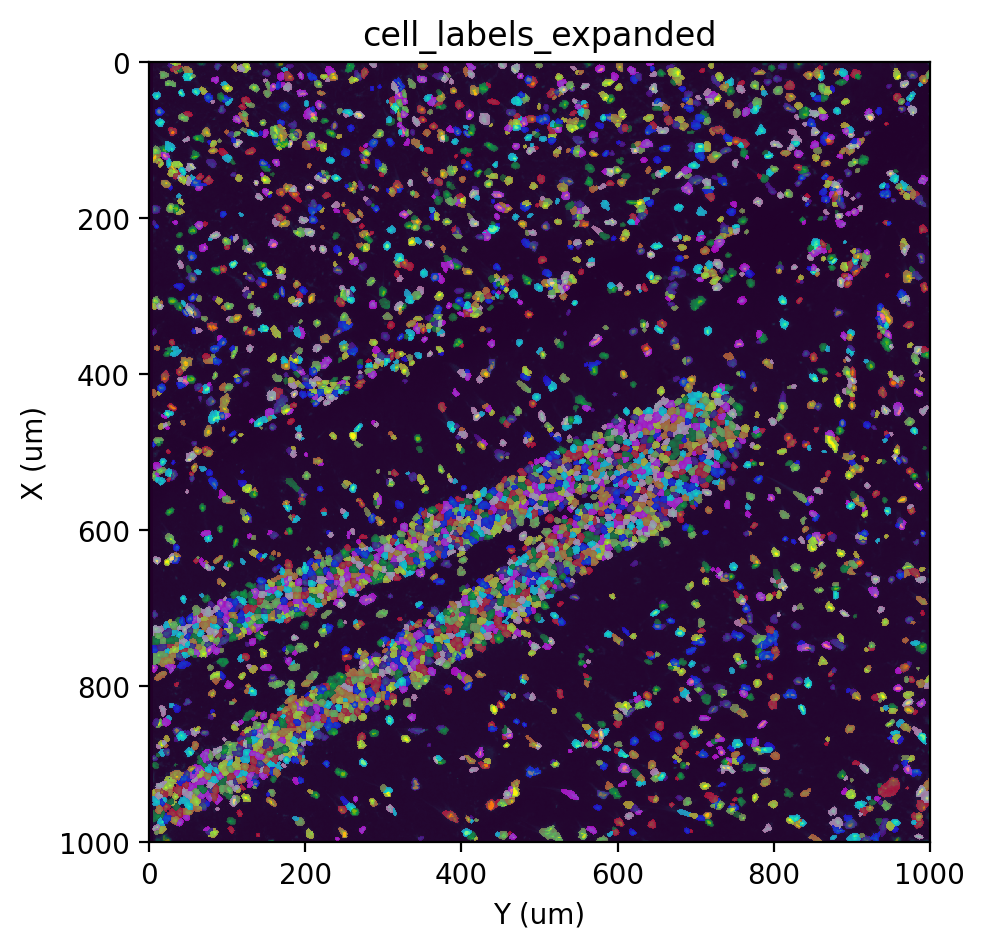

In [27]:
st.cs.expand_labels(
    adata, 'cell_labels', distance=2, out_layer='cell_labels_expanded'
)

fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'cell_labels_expanded', labels=True, alpha=0.5, ax=ax)

In [29]:
cell_adata = st.io.read_bgi(
    'SS200000135TL_D1_all_bin1.txt.gz',
    segmentation_adata=adata,
    labels_layer='cell_labels_expanded',
)
cell_adata

|-----> <select> cell_labels_expanded layer in AnnData Object
|-----> Using labels provided with `segmentation_adata` and `labels_layer` arguments.
|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


AnnData object with n_obs × n_vars = 4155 × 19815
    obs: 'area'
    uns: '__type', 'pp', 'spatial'
    obsm: 'spatial', 'contour', 'bbox'
    layers: 'spliced', 'unspliced'